# 10. 클러스터와 작업 큐

- 클러스터가 필요한 이유
- 클러스터링에 드는 비용
- multiprocessing 해법을 클러스터를 사용한 해법으로 바꾸는 방법
- IPython 클러스터의 작동방식
- Dask 와 Swifter를 사용한 팬더스 병렬화 방법
- NSQ가 겅건한 프로덕션 시스템 구축에 도움이 되는 이유

## 10.1 클러스터링의 이점

요구사항에 따라서 시스템을 쉽게 키울 수 있다

## 10.2 클러스터링의 단점

- 각 컴퓨터의 설정이 다를 수도 있다
- 노드 사이의 데이터를 옮기는 latency의 문제가 있을 수 있다
- failure architecture
- 과도한 설정이 될 수 있다. 모든 장애에 대해 99.999%의 신뢰가 필요한 것은 아니다.
- 문서화가 반드시 필요하다

## 10.3 일반적인 클러스터링 설계

- 애드혹 지역 클러스터 구축
- 거대분산처리 클러스터
- 하드웨어 위 여러 다른 소프트웨어 아키텍쳐운영 (작업큐, 메시지큐, 메시지 버스)

## 10.4 클러스터화한 해법을 시작하는 방법

QA 와 test를 붙인다

## 10.5 클러스터 사용 시 고통을 피하는 방법

시스템 배포 시간과 비용을 적게한다
- fabfile
- salt.readthedocs
- getchef
- puppetlabs

매일 상태보고를 하고 조기 경보 시스템을 만든다
- pingdom
- serverdensity
- deadmanswitch


## 10.6 두 가지 클러스터링 솔루션: IPython, NSQ

### 10.6.1 IPython Parallel을 사용해 연구 지원하기

- 한대의 멀티코어 컴퓨터에 사용한다.
- IPython이 local 과 remote의 인터페이스가 되어서 데이터를 여러 엔진에 보내고 작업을 remote 컴퓨터에 밀어넣을 수 있다.
- 내부적으로 zeroMQ를 사용한다.
- 엔진: 코드를 실행
- 컨트롤러: 인터페이스 제공
- 허브: 엔진 스케줄러 클라이언트 추적
- 스케줄러: 비동기 인터페이스 제공

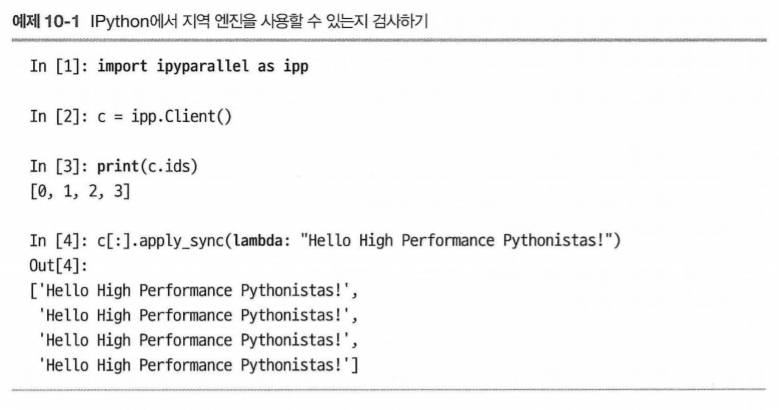

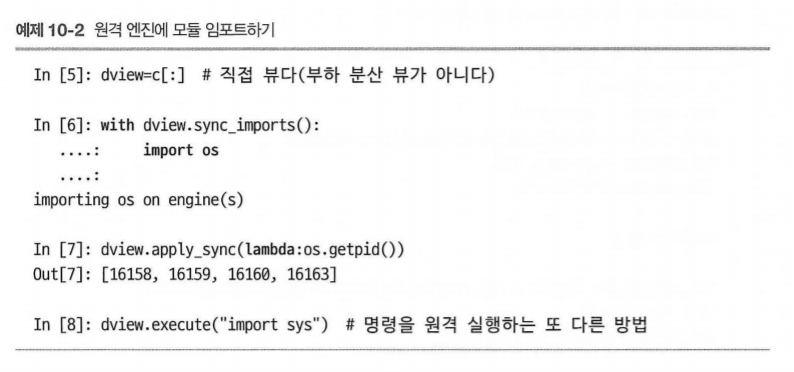

apply_async
ip 16158 16159 16160 16163 을 모듈로 import 한다

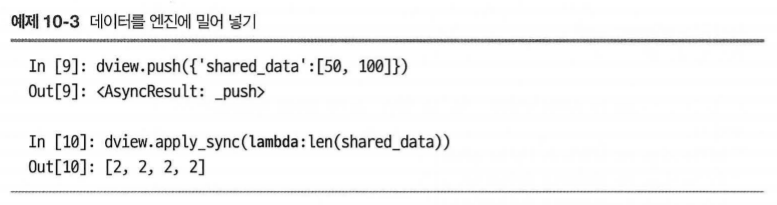

deview.push로 데이터를 넣는다

In [ ]:
import time
import ipyparallel as ipp
from ipyparallel import require
import os

@require('random')
def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    """Monte carlo estimate of the number of points in a      
       quarter circle using pure Python"""
    print(f"Executing estimate_nbr_points_in_quarter_circlewith {nbr_estimates:,} on pid {os.getpid()}")   
    nbr_trials_in_quarter_unit_circle = 0
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle
    return nbr_trials_in_quarter_unit_circle


if __name__ == "__main__":
    c = ipp.Client()
    nbr_engines = len(c.ids)
    print("We're using {} engines".format(nbr_engines))
    nbr_samples_in_total = 1e8
    nbr_parallel_blocks = 4

    dview = c[:]

    nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
    t1 = time.time()
    nbr_in_quarter_unit_circles = dview.apply_sync(estimate_nbr_points_in_quarter_circle, \
                                                   nbr_samples_per_worker)
    print("Estimates made:", nbr_in_quarter_unit_circles)

    nbr_jobs = len(nbr_in_quarter_unit_circles)
    pi_estimate = sum(nbr_in_quarter_unit_circles) * 4 / nbr_samples_in_total
    print("Estimated pi", pi_estimate)
    print("Delta:", time.time() - t1)


### 10.6.2 Dask로 팬더스 병렬화하기

In [ ]:
!pip install dask

In [ ]:
import dask.dataframe as dd

## 10.7 강건한 프로덕션 클러스터링을 위한 NSQ

프로덕션에 사용할 수 있는 큐시스템

한대의 코어가 명령을 내리고 나머지가 실행하는 것이 아니라, 여러 참가자가 메시지버스를 통해 서로 통신하는 시스템

### 10.7.1 큐

메시지를 큐에 보내고 큐는 메시지를 저장했다가 전달한다.

예를 들어 A라는 작업이 B라는 작업을 작동시킬 때 B라는 작업을 바로 작동시키는 것이 아니라, A작업이 큐에 B를 저장했다가 실행가능해질 때 B를 전달한다. 즉 버퍼역할을 한다. 이 떄 큐에 대용량의 작업이 들어올 수 있다. NSQ는 다수의 저장소 백엔드를 제공해 이를 해결한다.

### 10.7.2 출판사/구독자 pub-sub구조

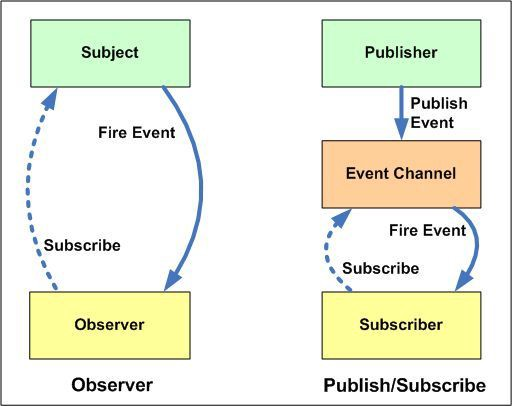

### 10.7.3 분산 소수 계산

In [ ]:
import json
from functools import partial
from math import sqrt

import nsq

# 소수를 찾는 함수
def is_prime(number):
    if number % 2 == 0:
        return False
    for i in range(3, int(sqrt(number)) + 1, 2):
        if number % i == 0:
            return False
    return True

# data를 publish한다.
def write_message(topic, data, writer):
    response = writer.pub(topic, data)
    if isinstance(response, nsq.Error):
        print("Error with Message: {}: {}".format(data, response))
        return write_message(data, writer)
    else:
        print("Published Message: ", data)


def calculate_prime(message, writer):
    data = json.loads(message.body)

    # number가 prime인지 bool 판단.
    prime = is_prime(data["number"])
    data["prime"] = prime
    if prime:
        topic = "prime"
    else:
        topic = "non_prime"

    output_message = json.dumps(data).encode("utf8")
    # 메시지를 queue에 publish한다.
    write_message(topic, output_message, writer)
    # 메시지를 다 보낸 후 msq에 신호를 보낸다
    message.finish()  # <1>


if __name__ == "__main__":
    # publisher 만들기
    writer = nsq.Writer(["127.0.0.1:4150"])
    # parameter를 pub로 고정한 소수 찾기 함수
    handler = partial(calculate_prime, writer=writer)
    # sub를 만들어 run한다.
    reader = nsq.Reader(
        message_handler=handler,
        nsqd_tcp_addresses=["127.0.0.1:4150"],
        topic="numbers",
        channel="worker_group_a",
    )
    nsq.run()

    # ( 자신을 중단시킬 때 아직 전달하지 못한 메시지를 디스크에 저장하므로
    # 대부분 손상하지 않은 데이터를 전송할 수 있다. 특정 메시지 응답 전에 실행이 중단되면 해당 메시지를 다른 소비자에게 전달한다.)
    

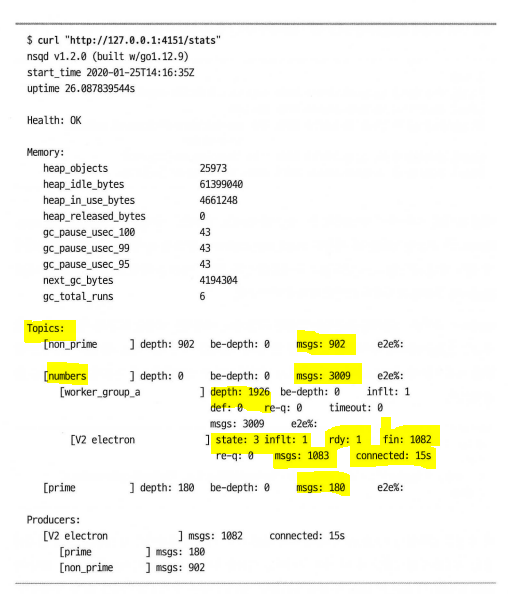

- numbers 주제에 worker_group_a 구독자 그룹이 있다. non_prime과 prime에는 구독자 소비자가 없다
- numbers 메시지를 하나 처리하는데에 15s 이 걸린다. 메시지 추가가 처리속도보다 빠르다 (1926개가 쌓여있다.) 구독 소비자를 늘리면 속도가 빨라진다.
- 현재 처리중인 메시지가 1개 이며 rdy 1개 끝낸 것은 1082개 큐에 쌓여있는 것이 1926개로 총 3009개의 메시지가 생성되었다.

## 10.8 살펴볼 만한 다른 클러스터링 도구들
그 중 아마존의 단순 큐 서비스 Simple Queue Service (SQS)

## 10.9 도커

- 기능: 운영체제 수준의 가상화 인스턴스를 제공
- 리눅스 cgroups


### 10.9.1 도커의 성능

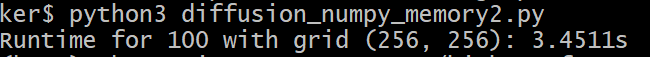

In [ ]:
# requirements.txt

numpy>=1.18.0

In [ ]:
# Dockerfile

FROM python:3.7

WORKDIR /usr/src/app
COPY requirements.txt ./
RUN pip install --no-cache-dir -r requirements.txt

# 지역 디렉터리 파일을 컨테이너로 복사한다.
COPY . .
CMD python ./diffusion_numpy_memory2.py


In [ ]:
# Makefile

build:
	docker build -t ${USER}/diffusion2d:numpy-memory2 -t micha/diffusion2d:latest .

run: build
	docker run ${USER}/diffusion2d:latest

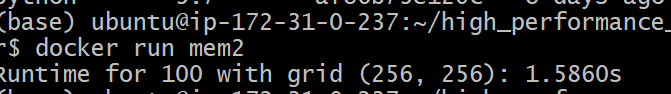



### 10.9.2 도커의 장점

- docker images -a
- docker push
- docker pull
도커 이미지를 공유할 수 있다

쿠버네티스를 사용해 컨테이너들을 관리할 수 있다.
관련 강의들
- https://www.inflearn.com/course/%EC%BF%A0%EB%B2%84%EB%84%A4%ED%8B%B0%EC%8A%A4-%EC%9E%85%EB%AC%B8
- https://www.inflearn.com/course/%EA%B3%B5%EC%9D%B8-%EC%BF%A0%EB%B2%84%EB%84%A4%ED%8B%B0%EC%8A%A4-%EA%B4%80%EB%A6%AC%EC%9E%90
- https://www.inflearn.com/course/%EB%A6%AC%EB%88%85%EC%8A%A4-%EC%9E%85%EB%AC%B8

## 10.10 마치며

- 클러스터가 필요한 이유
- 클러스터링에 드는 비용
- multiprocessing 해법을 클러스터를 사용한 해법으로 바꾸는 방법
- IPython 클러스터의 작동방식
- Dask 와 Swifter를 사용한 팬더스 병렬화 방법
- NSQ가 겅건한 프로덕션 시스템 구축에 도움이 되는 이유